In [1]:
# set up
import numpy as np
import os
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Activation
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras import optimizers
from keras import regularizers
from keras.utils import to_categorical
import gc

Using TensorFlow backend.


In [2]:
# load data
num_frames = 15
npy_path = os.getcwd() + '/datasets/'
train = np.load(npy_path + 'cache/train_num_videos4270_num_frame15.npz')
Xtr = train['Xtrain']
ytr = train['ytrain']
print('Xtrain shape: ', Xtr.shape)
print('ytrain shape: ', ytr.shape)

Xtrain shape:  (64050, 7, 7, 512)
ytrain shape:  (4270,)


In [3]:
# extract sample images per video
sample = 10
Xtr_re = Xtr.reshape((-1, 15, 7, 7, 512))[:, :sample, :, :, :]
Xtr_re = Xtr_re.reshape((-1, 7, 7, 512))
print('reshape xtrain: ', Xtr_re.shape)

reshape xtrain:  (42700, 7, 7, 512)


In [4]:
ytr_re = ytr.reshape((-1, 1))
ytr_re = np.repeat(ytr_re, sample, axis = 1).reshape((Xtr_re.shape[0],))
print('reshape ytrain: ', ytr_re.shape)

reshape ytrain:  (42700,)


In [5]:
del Xtr
del ytr
gc.collect()

6

In [6]:
def classifier(optimizer, reg = 0.01):
    x = Input(shape = (7, 7, 512))
    x_flat = Flatten()(x)
    fc1 = Dense(units = 4096, kernel_regularizer=regularizers.l2(reg))(x_flat)
    fc2 = Dense(units = 256, kernel_regularizer=regularizers.l2(reg))(fc1)
    fc3 = Dense(units = 10, kernel_regularizer=regularizers.l2(reg))(fc2)
    sf = Activation('softmax')(fc3)
    model = Model(inputs=x, outputs=sf)
    model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [7]:
def train(Xtr, ytr, model, epochs, bsize, split_ratio = 0.2, verbose = False):
    
    print('Model is Training...')
    checkpointer = ModelCheckpoint(filepath='frame_classification_weights.hdf5', verbose=1, save_best_only=True)

    # reduce learning rate when on plateau
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
    
    hist = model.fit(Xtr, ytr, epochs=epochs, batch_size= bsize, validation_split = split_ratio, \
                             verbose = verbose, callbacks=[checkpointer, reduceLR])
    return hist

In [12]:
cf = None
gc.collect()

0

In [8]:
# training
adam = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=1e-6)
cf = classifier(optimizer = adam, reg = 0.01)
ytr_re = to_categorical(ytr_re, num_classes = 10)
hist = train(Xtr_re, ytr_re, cf, epochs = 20, bsize = 64, verbose = True)

Model is Training...
Train on 34160 samples, validate on 8540 samples
Epoch 1/20
34160/34160 [==============================] - 118s - loss: 82.3526 - acc: 0.4502 - val_loss: 81.7628 - val_acc: 0.4219
Epoch 2/20
34160/34160 [==============================] - 115s - loss: 77.0249 - acc: 0.6629 - val_loss: 77.8433 - val_acc: 0.5294
Epoch 3/20
34160/34160 [==============================] - 115s - loss: 73.5146 - acc: 0.7467 - val_loss: 75.8289 - val_acc: 0.5138
Epoch 4/20
34160/34160 [==============================] - 115s - loss: 70.5824 - acc: 0.7844 - val_loss: 73.1696 - val_acc: 0.5287
Epoch 5/20
34160/34160 [==============================] - 115s - loss: 67.7758 - acc: 0.8025 - val_loss: 70.5660 - val_acc: 0.5290
Epoch 6/20
34160/34160 [==============================] - 116s - loss: 64.8525 - acc: 0.8251 - val_loss: 67.9805 - val_acc: 0.5219
Epoch 7/20
34160/34160 [==============================] - 115s - loss: 61.9627 - acc: 0.8381 - val_loss: 65.1120 - val_acc: 0.5316
Epoch 8/20
34

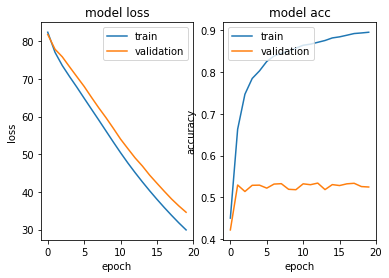

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot(hist):
    '''
    plot training history accuracy and loss between training sets and validation sets
    '''
    plt.subplot(121)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')

    plt.subplot(122)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model acc')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
plot(hist)

In [29]:
from collections import Counter
def predict(Xte, yte, model):
    '''
    Xte: test feature data (sample_size, temporal/frames, height, width, filter_num/channels)
    yte: test true labels (sample_size, )
    '''
    model.load_weights('frame_classification_weights.hdf5')
    ypred = model.predict(Xte)
    ypred = np.argmax(ypred, axis = 1)
    ypred = ypred.reshape((-1, 15))
    ypred_test = []
    for s in range(ypred.shape[0]):
        yr = ypred[s, :].ravel()
        counts = Counter(yr)
        ypred_test.append(counts.most_common(1)[0][0])
    
    acc = np.mean(yte == ypred_test)
    print('Video Classification Accuracy: {0}'.format(acc))
    return ypred_test

In [20]:
# clear memory
# del Xtr_re
# del ytr_re
gc.collect()

42

In [21]:
# load test data
Xte = np.load(npy_path + 'Xtest_all_' + str(num_frames) + 'frames.npy')
yte = np.load(npy_path + 'ytest_all_' + str(num_frames) + 'frames.npy')
print('Xtest shape: ', Xte.shape)
print('ytest shape: ', yte.shape)

Xtest shape:  (27450, 7, 7, 512)
ytest shape:  (1830,)


In [26]:
Xte_re = Xte.reshape((-17, 7, 7, 512))
yte_re = yte.copy()
print('reshape Xte: ', Xte_re.shape)
print('reshape yte: ', yte_re.shape)

reshape Xte:  (27450, 7, 7, 512)
reshape yte:  (1830,)


In [30]:
ypred = predict(Xte_re, yte_re, cf)

Video Classification Accuracy: 0.5781420765027322


In [32]:
from sklearn.metrics import classification_report
def classification_report_func(model, yte, ypred):
    target_names = ['music', 'gaming', 'sports/actions', 'news/events/politics', 'movie/comedy', 'vehicles/autos',\
               'howto', 'animals/pets', 'kids/family', 'food/drink']
    print(classification_report(yte, ypred, target_names = target_names))
classification_report_func(cf, yte, ypred)

                      precision    recall  f1-score   support

               music       0.53      0.29      0.37       195
              gaming       0.52      0.64      0.58       122
      sports/actions       0.62      0.77      0.69       288
news/events/politics       0.45      0.45      0.45       133
        movie/comedy       0.43      0.62      0.51       220
      vehicles/autos       0.77      0.77      0.77       229
               howto       0.64      0.48      0.55       163
        animals/pets       0.58      0.50      0.53       145
         kids/family       0.49      0.51      0.50       152
          food/drink       0.79      0.55      0.65       183

         avg / total       0.59      0.58      0.57      1830



In [33]:
del Xte_re
del yte_re

In [35]:
gc.collect()

0